In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
gpu_strategy = tf.distribute.MirroredStrategy()
print('No of replicas: ', gpu_strategy.num_replicas_in_sync)

No of replicas:  1


In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia')

Skipping, found downloaded files in "./chest-xray-pneumonia" (use force=True to force download)


In [ ]:
# Paths
INPUT_DIR = "/content/chest-xray-pneumonia/chest_xray/chest_xray"
OUTPUT_DIR = "/content/chest_xray_split"
SPLITS = ["train", "val", "test"]

# Collect all images by class (look 2 levels deep)
images_by_class = {}

for split in SPLITS:
    split_path = os.path.join(INPUT_DIR, split)
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_path = os.path.join(split_path, class_name)
        if os.path.exists(class_path):
            images_by_class[f"{split}_{class_name}"] = [
                os.path.join(class_path, f) for f in os.listdir(class_path)
                if f.lower().endswith((".jpg", ".jpeg", ".png"))
            ]

### Debug: Print counts per split
for key, files in images_by_class.items():
    print(f"{key}: {len(files)} images")

# Flatten into class-separated lists (ignoring original splits)
all_normal_files = []
all_pneumonia_files = []

for key, files in images_by_class.items():
    if "NORMAL" in key:
        all_normal_files.extend(files)
    elif "PNEUMONIA" in key:
        all_pneumonia_files.extend(files)

print()
print(f"\nTotal NORMAL: {len(all_normal_files)}")
print(f"Total PNEUMONIA: {len(all_pneumonia_files)}")
print()

# Create output folder structure
for split in SPLITS:
    for label in ["NORMAL", "PNEUMONIA"]:
        os.makedirs(os.path.join(OUTPUT_DIR, split, label), exist_ok=True)

# Split images deterministically (80% train, 10% val, 10% test)
def split_and_save(file_list, class_name):
    train_files, temp_files = train_test_split(file_list, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    split_dict = {
        "train": train_files,
        "val": val_files,
        "test": test_files
    }

    for split, files in split_dict.items():
        for filepath in tqdm(files, desc=f"Saving {split}/{class_name}"):
            img = cv2.imread(filepath)
            if img is None:
                continue
            filename = os.path.basename(filepath)
            save_path = os.path.join(OUTPUT_DIR, split, class_name, filename)
            cv2.imwrite(save_path, img)

# Process each class
split_and_save(all_normal_files, "NORMAL")
split_and_save(all_pneumonia_files, "PNEUMONIA")

print("✅ Dataset saved in:", OUTPUT_DIR)

train_NORMAL: 1341 images
train_PNEUMONIA: 3875 images
val_NORMAL: 8 images
val_PNEUMONIA: 8 images
test_NORMAL: 234 images
test_PNEUMONIA: 390 images


Total NORMAL: 1583
Total PNEUMONIA: 4273



Saving test/PNEUMONIA: 100%|██████████| 428/428 [00:04<00:00, 102.31it/s]

✅ Dataset saved in: /content/chest_xray_split


In [ ]:
from collections import Counter


In [ ]:
# Define the root directory that contains the split folders
ROOT_DIR = "/content/chest_xray_split"

# Keep track of the splits you want to load
SPLITS = ["train", "val", "test"]

# Map string labels to integers for model-friendly targets
LABEL_MAP = {"NORMAL": 0, "PNEUMONIA": 1}

def load_split(split_name, target_size=(224, 224), normalize=True):
    """
    Read every image inside ROOT_DIR / split_name / class_label,
    convert it to grayscale, resize, normalize (optional),
    expand the channel dimension, and return the images with labels.
    """
    images = []
    labels = []
    bad_files = []

    # Build the split path
    split_path = os.path.join(ROOT_DIR, split_name)

    for class_name, class_index in LABEL_MAP.items():
        class_path = os.path.join(split_path, class_name)
        if not os.path.exists(class_path):
            continue

        # Iterate through files in the class folder
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)

            # Get file extension safely
            _, ext = os.path.splitext(filename)
            if ext.lower() not in {".jpg", ".jpeg", ".png"}:
                continue

            # Read the image directly in grayscale
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                bad_files.append(image_path)
                continue

            # Resize to a fixed target size
            if target_size is not None:
                img = cv2.resize(img, target_size)

            # Normalize pixel values (0–1 range)
            if normalize:
                img = img.astype("float32") / 255.0

            # Expand channel axis to (H, W, 1)
            img = np.expand_dims(img, axis=-1)

            images.append(img)
            labels.append(class_index)

    if bad_files:
        print(f"[WARNING] Skipped {len(bad_files)} corrupted files in '{split_name}'")

    return images, labels

# Load every split using the reusable function
x_train, y_train = load_split("train")
x_val, y_val     = load_split("val")
x_test, y_test   = load_split("test")

# Convert lists to NumPy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_val,   y_val   = np.array(x_val),   np.array(y_val)
x_test,  y_test  = np.array(x_test),  np.array(y_test)

# Display the dataset stats
print(f"Train set: {x_train.shape}, labels: {y_train.shape}")
print(f"Validation set: {x_val.shape}, labels: {y_val.shape}")
print(f"Test set: {x_test.shape}, labels: {y_test.shape}")

# Show class balance
print("Class balance in train:", Counter(y_train))
print("Class balance in val:  ", Counter(y_val))
print("Class balance in test: ", Counter(y_test))


Train set: (4684, 224, 224, 1), labels: (4684,)
Validation set: (585, 224, 224, 1), labels: (585,)
Test set: (587, 224, 224, 1), labels: (587,)
Class balance in train: Counter({np.int64(1): 3418, np.int64(0): 1266})
Class balance in val:   Counter({np.int64(1): 427, np.int64(0): 158})
Class balance in test:  Counter({np.int64(1): 428, np.int64(0): 159})


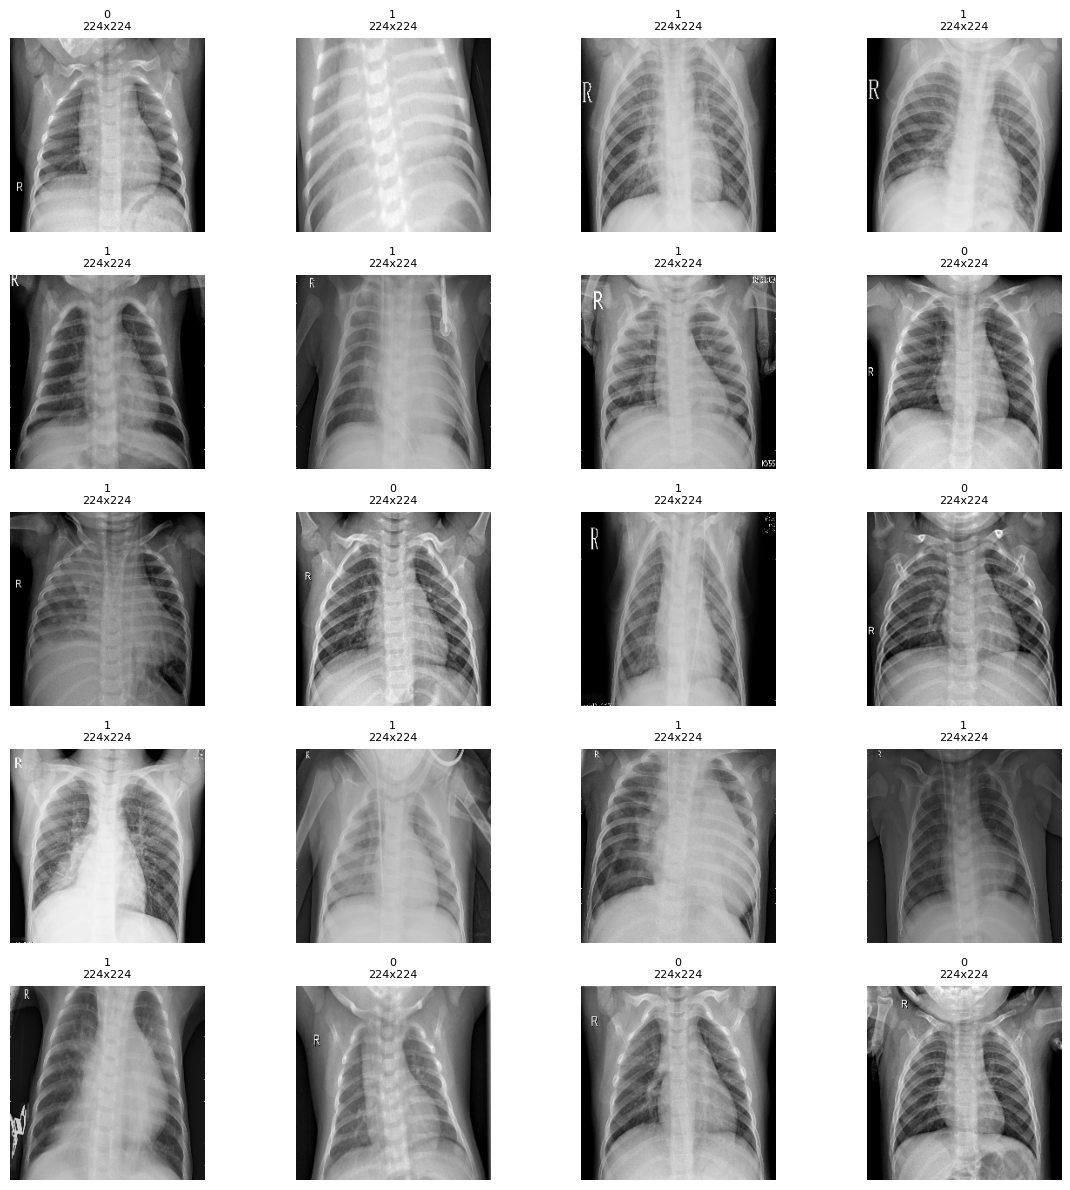

In [ ]:
# Pick 20 random indices
indices = random.sample(range(len(x_train)), 20)

plt.figure(figsize=(12, 12))

for i, idx in enumerate(indices):
    plt.subplot(5, 4, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    img_shape = x_train[idx].shape
    plt.title(f"{ y_train[idx]}\n{img_shape[0]}x{img_shape[1]}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_val: {x_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (4684, 224, 224, 1)
Shape of y_train: (4684,)
Shape of x_val: (585, 224, 224, 1)
Shape of y_val: (585,)
Shape of x_test: (587, 224, 224, 1)
Shape of y_test: (587,)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Convert your existing NumPy arrays to PyTorch tensors
x_train_tensor = torch.FloatTensor(x_train).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_train_tensor = torch.LongTensor(y_train)

x_val_tensor = torch.FloatTensor(x_val).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_val_tensor = torch.LongTensor(y_val)

x_test_tensor = torch.FloatTensor(x_test).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_test_tensor = torch.LongTensor(y_test)

print(f"Train: {x_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Val: {x_val_tensor.shape}, {y_val_tensor.shape}")
print(f"Test: {x_test_tensor.shape}, {y_test_tensor.shape}")

Train: torch.Size([4684, 1, 224, 224]), torch.Size([4684])
Val: torch.Size([585, 1, 224, 224]), torch.Size([585])
Test: torch.Size([587, 1, 224, 224]), torch.Size([587])


In [ ]:
# Alternate to TensorDataset but from scratch :)
class ChestXRayDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    # Required by DataLoader to know when to stop iterating
    def __len__(self):
        return len(self.images)

    # Required by DataLoader to fetch individual samples during batch creation
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

# Create datasets
train_dataset = ChestXRayDataset(x_train_tensor, y_train_tensor)
val_dataset = ChestXRayDataset(x_val_tensor, y_val_tensor)
test_dataset = ChestXRayDataset(x_test_tensor, y_test_tensor)

In [ ]:
# Calculate class weights for sampler
class_counts = Counter(y_train)
total_samples = len(y_train)
class_weights = {0: total_samples / class_counts[0],  # NORMAL
                 1: total_samples / class_counts[1]}   # PNEUMONIA

# Create sample weights for each training example
sample_weights = [class_weights[label.item()] for label in y_train_tensor]

# Create weighted sampler
weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=weighted_sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class PneumoniaCNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):  # 1 in channels: Grayscaled images, 2 classes: NORMAL and PNEUMONIA
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),    # 3x3 conv
                nn.BatchNorm2d(out_c),                   # BatchNorm
                nn.ReLU(inplace=True),                   # Relu
                nn.Conv2d(out_c, out_c, 3, padding=1),   # 3x3 conv (more complex features)
                nn.BatchNorm2d(out_c),                   # BatchNorm
                nn.ReLU(inplace=True),                   # Relu
                nn.MaxPool2d(2)                          # MaxPol (reduce dimensions by half)
            )

        self.layer1 = conv_block(in_channels, 32)        # first conv block (1 -> 32)
        self.layer2 = conv_block(32, 64)                 # second conv block (32 -> 64)
        self.layer3 = conv_block(64, 128)                # third conv block (64 -> 128)
        self.layer4 = conv_block(128, 256)               # forth conv block (128 -> 256)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # converts size to (256, 1, 1)
        self.dropout = nn.Dropout(0.4)                   # random 40% dropout
        self.fc = nn.Linear(256, num_classes)            # fully connected layer (256 -> 2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Initialize the model
model = PneumoniaCNN(num_classes=2)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 1,174,114


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Handles multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move data to device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
# Training loop
def train_model(model, train_loader, val_loader, epochs=20):
    best_val_acc = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = to_device(images, device), to_device(labels, device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = to_device(images, device), to_device(labels, device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_pneumonia_model.pth')

    print(f'Best validation accuracy: {best_val_acc:.2f}%')

# Train the model
train_model(model, train_loader, val_loader, epochs=20)

Epoch [1/20]
Train Loss: 0.2963, Train Acc: 88.41%
Val Loss: 0.2337, Val Acc: 87.69%
--------------------------------------------------
Epoch [2/20]
Train Loss: 0.2223, Train Acc: 91.03%
Val Loss: 1.0716, Val Acc: 66.32%
--------------------------------------------------
Epoch [3/20]
Train Loss: 0.1902, Train Acc: 92.76%
Val Loss: 0.6162, Val Acc: 73.33%
--------------------------------------------------
Epoch [4/20]
Train Loss: 0.1724, Train Acc: 93.42%
Val Loss: 0.3649, Val Acc: 89.40%
--------------------------------------------------
Epoch [5/20]
Train Loss: 0.1497, Train Acc: 94.45%
Val Loss: 0.3511, Val Acc: 83.59%
--------------------------------------------------
Epoch [6/20]
Train Loss: 0.1524, Train Acc: 94.60%
Val Loss: 0.5847, Val Acc: 77.61%
--------------------------------------------------
Epoch [7/20]
Train Loss: 0.1241, Train Acc: 95.20%
Val Loss: 0.0888, Val Acc: 97.09%
--------------------------------------------------
Epoch [8/20]
Train Loss: 0.1310, Train Acc: 95.1

In [ ]:
import torch.nn.functional as F

# Model evaluation
def evaluate_model(model, test_loader):
    model.eval()
    model.load_state_dict(torch.load('best_pneumonia_model.pth'))

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = to_device(images, device), to_device(labels, device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities[:, 1].cpu().numpy())  # Pneumonia probability

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Test AUC: {auc:.4f}")

# Evaluate
evaluate_model(model, test_loader)

Test Accuracy: 0.9642
Test Precision: 0.9641
Test Recall: 0.9642
Test F1-Score: 0.9641
Test AUC: 0.9921


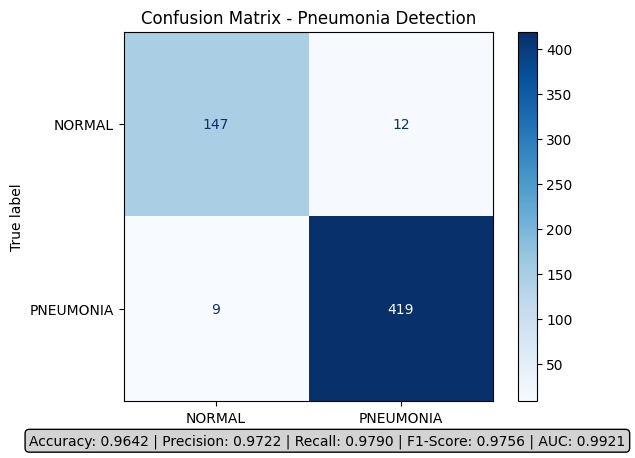

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_confusion_matrix_and_metrics(model, test_loader, device):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = probs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs[:, 1].cpu().numpy())  # Probability for class 1 (PNEUMONIA)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_probs)

    # Confusion Matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=["NORMAL", "PNEUMONIA"],
        cmap="Blues",
        values_format="d"
    )

    plt.figtext(
        0.02, 0.02,
        f'Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f} | AUC: {auc:.4f}',
        ha='left', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray")
    )
    disp.ax_.set_title("Confusion Matrix - Pneumonia Detection")
    plt.show()

# Usage:
plot_confusion_matrix_and_metrics(model, test_loader, device)


In [ ]:
import torch

torch.save(model.state_dict(), "pneumonia_cnn_weights.pth")


In [ ]:
from google.colab import files
files.download("pneumonia_cnn_weights.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>